# 3 Monte Carlo Estimation

## Expectation and Variance

We can use Monte Carlo to estimate the expectation and the variance of a distribution.

**Example** $A,B\sim N(0,1)$ are independent. Estimate the expectation and the variance of $|A-B|$.

We can generate $m$ samples $(a_i,b_i)$.

$$\begin{aligned} \mathbb E|A-B|\approx \frac 1m\sum_{i=1}^m |a_i-b_i|
\quad\quad\text{and}\quad\quad \text{Var}|A-B|\approx {\frac 1m\sum_{i=1}^m |a_i-b_i|^2-\left(\frac 1m\sum_{i=1}^m |a_i-b_i|\right)^2}
\end{aligned}$$

Note: true values are given by $\mathbb E|A-B|=\frac{2}{\sqrt\pi}\approx 1.1284$ and $\text{Var}|A-B|=\frac{2\pi -4}{\pi}\approx 0.7268$.

In [13]:
import numpy as np
m = 10000
samples = np.random.randn(2, m)
samples = np.abs(samples[0] - samples[1])
E = np.mean(samples)
Var = np.mean(samples**2) - E**2
print("E   = ", E, "\nVar = ", Var)

E   =  1.127735953938156 
Var =  0.7105818062739038


### Trimmed Mean

Sometimes we can use trimmed mean to estimate the expectation. To be specific, if we have $n$ samples sorted as $X_{(1)}\leqslant X_{(2)}\leqslant\cdots\leqslant X_{(n)}$ (ordered statistics), then the trimmed mean is defined as

$$\bar X_{[-k]} = \frac 1{n-2k}\sum_{i=k+1}^{n-k}X_{(i)}.$$

That is to discard the smallest $k$ and the largest $k$ samples. This avoids the influence of outliers.

<br>

To estimate the MSE of the method of trimmed mean on a certain problem, we can repeat multiple times and calculate the MSE of the results. It is expected that trimmed mean helps reduce MSE.

In [29]:
from functools import partial
import numpy as np
def noised_gaussian(n, p = .9, var1 = 1, var2 = 100):
    # A mixed gaussian distribution that has probability p to be N(0, var1) and 1-p to be N(0, var2).
    ps = np.random.random(n) < p
    samples = np.random.randn(n)
    samples = np.where(ps, samples * np.sqrt(var1), samples * np.sqrt(var2))
    return samples

def trimed_mean(samples, k = 0):
    if k == 0: return np.mean(samples)
    samples = np.sort(samples)
    return np.mean(samples[k : -k])

def simulate_trimed_mean_MSE(distribution, estimator, n = 1000, times = 1000, true_value = 0.):
    s = 0
    for time_ in range(times):
        s += (estimator(distribution(n)) - true_value)**2
    return s / times

# test trimmed mean with different k
for k_ in [0, 10, 50, 450]:
    estimator = partial(trimed_mean, k = k_)
    print("k = %3d "%k_, "MSE =", simulate_trimed_mean_MSE(noised_gaussian, estimator, n = 1000, true_value = 0.))

k =   0  MSE = 0.011051793687713337
k =  10  MSE = 0.008204855245958247
k =  50  MSE = 0.0017579262863889676
k = 450  MSE = 0.0017558976326968272


## Hypothesis Testing

### Confidence Level

When asymptotic normality is assumed, we can simply use $\bar X\pm z_{\alpha/2}\frac{\sigma}{\sqrt n}$ to construct a confidence interval.

However, when normality is not available, we can use Monte Carlo to determine the confidence level of a confidence interval. Repeatedly compute the confidence interval multiple times on different samples, and calculate the proportion of the confidence intervals that contain the true value.

In [72]:
import numpy as np
from scipy.stats import chi2, norm

def distribution(n = 1000):
    return np.random.randn(n) * 2 # variance = 4

# estimate the CI for the variance of the normal distribution
def estimator(samples):
    # P((n-1)Var / sigma^2 > t) = P(chi^2(n-1) > t) = .95
    # <=> sigma^2 < (n-1)Var / t
    S = ((samples - samples.mean())**2).sum()
    r_bound = (S / chi2.ppf(.05, samples.size-1)) ** .5
    return (0, r_bound)

def estimate_confidence_level(distribution, estimator, n = 20, times = 1000, true_value = 2.):
    s = 0
    for time_ in range(times):
        l, r = estimator(distribution(n))
        if l <= true_value <= r:
            s += 1
    return s / times

print('Estimated Confidence Level =', estimate_confidence_level(distribution, estimator))

Estimated Confidence Level = 0.948


### Power and Type II Error

Consider the following hypothesis testing problem.

$$\begin{aligned} H_0: \theta\in\Theta_0\quad\quad\text{vs.}\quad\quad H_1: \theta\notin\Theta_0 \end{aligned}$$

Given observed data $X$, we can reject $H_0$ if $\sup_{\theta\in\Theta_0}L(\theta|X)<c$ for some $c$. The probability of rejecting $H_0$ when $H_0$ is true is called the **Type I error**. The probability of rejecting $H_0$ when $H_0$ is false is called the **power**.

### Skewness Test

Let $X$ be a random variable. Its skewness is defined by

$$\text{Skew}(X)=\frac{\mathbb E(X-\mu)^3}{\sigma^3}$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of $X$. If $\text{Skew}(X)=0$, then $X$ is symmetric. When $\text{Skew}(X)>0$, then $X$ is right-skewed. When $\text{Skew}(X)<0$, then $X$ is left-skewed.

**Theorem** Let $\kappa_r = \mathbb E(X - \mathbb EX)^r$ to be the central moment. Suppose $\kappa_6$ is finite. Define

$$b = \frac{\frac 1n\sum_{i=1}^n (X_i - \bar X)^3}{\left[\frac 1n\sum_{i=1}^n (X_i - \bar X)^2\right]^{\frac 32}}.$$

Then we have asymptotic normality $\sqrt n (b- \text{Skew}(X))\to N(0,v)$ where 

$$v =\frac{36 \kappa_{2}^{5} - 24 \kappa_{2}^{3} \kappa_{4} + 35 \kappa_{2}^{2} \kappa_{3}^{2} + 4 \kappa_{2}^{2} \kappa_{6} - 12 \kappa_{2} \kappa_{3} \kappa_{5} + 9 \kappa_{3}^{2} \kappa_{4}}{4 \kappa_{2}^{5}}.$$

In particular, if $X$ is normal, then $v=6$.

**Proof** From [https://marcgenton.github.io/2021.AHG.bookchap.pdf](https://marcgenton.github.io/2021.AHG.bookchap.pdf) we have the following result of joint asymptotic normality (note that $\kappa_1 = 0$):


$$\begin{aligned}
\sqrt n \left[\begin{matrix}\frac 1n\sum_{i=1}^n (X_i - \bar X)^2- 
\kappa_2\\ \frac 1n\sum_{i=1}^n (X_i - \bar X)^3 - \kappa_3
\end{matrix}\right]\rightarrow_d N\left\{\mathbf 0,
\left[\begin{matrix}- \kappa_{2}^{2} + \kappa_{4} & - 4 \kappa_{2} \kappa_{3} + \kappa_{5}\\- 4 \kappa_{2} \kappa_{3} + \kappa_{5} & 9 \kappa_{2}^{3} - 6 \kappa_{2} \kappa_{4} - \kappa_{3}^{2} + \kappa_{6}\end{matrix}\right]
\right\}
\end{aligned}.$$

Apply the Slutsky theorem: if $\sqrt n(Y -c)\rightarrow_d N(0,\Sigma)$, then $\sqrt n(g(Y) -g(c))\rightarrow_d N(0,\nabla g(c)^T\Sigma \nabla g(c))$. Taking $g = \left[\begin{matrix}x_1\\ x_2\end{matrix}\right]\mapsto  {x_2}{x_1^{-\frac 32}}$ yields the result.

<!-- $Y=\left[\begin{matrix}\frac 1n\sum_{i=1}^n (X_i - \bar X)^2\\ \frac 1n\sum_{i=1}^n (X_i - \bar X)^3\end{matrix}\right]$ and $c=\left[\begin{matrix}\kappa_2\\ \kappa_3\end{matrix}\right]$ -->

In particular, for normal distribution $X\sim N(0,\sigma^2)$, $\kappa_r = \sigma^r (r-1)!!$ for even $r$ while $\kappa_r = 0$ for odd $r$.

In [160]:
import sympy as sp
from IPython.display import display, Math

x, y, sigma = sp.symbols('x y \\sigma', real = True, positive = True)
# central moments of the normal distribution
moments = [(sigma**n * sp.factorial2(n-1)) if n % 2 == 0 else 0 for n in range(10)]
moments_std = [sp.Symbol(f'\\kappa_{i}') for i in range(10)]

def get_S(inds, moments = None):
    """
    Return the covariance matrix of the sample central moments of order = inds.
    See Preposition 2 at https://marcgenton.github.io/2021.AHG.bookchap.pdf

    Parameter `moments` is a list that moments[i] = E((X - \mu)^i).
    """
    inds = list(inds)
    m = max(inds)
    if moments is None:
        moments = [sp.Symbol(f'\\kappa_{i}') for i in range(2*m+1)]
    moments[0] = 1
    # moments[1] = 0
    S = sp.zeros(m, m)
    for i in range(m):
        for j in range(m):
            # S[i,j] = Cov(E[X^(i+1)], E[X^(j+1)]) where X is centered
            S[i, j] = moments[i+j+2] - moments[i+1] * moments[j+1]

    C = sp.eye(m)
    for i in range(1, m):
        C[i, 0] = -(i+1) * moments[i]
    S = C * S * C.T
    inds = [i-1 for i in inds]
    return S[inds, :][:, inds]

func = y / x**sp.Rational(3,2)
value = {x: sp.Symbol('\\kappa_2'), y: sp.Symbol('\\kappa_3')}
grad = sp.Matrix([func.diff(x), func.diff(y)])
S = get_S([2,3], moments = None).expand()
var = (grad.T * S * grad)[0,0].subs(value).factor() # apply Slutsky's theorem
var = var.subs(sp.Symbol('\\kappa_1'), 0).factor()
print('Var =')
display(var)

Var =


(36*\kappa_2**5 - 24*\kappa_2**3*\kappa_4 + 35*\kappa_2**2*\kappa_3**2 + 4*\kappa_2**2*\kappa_6 - 12*\kappa_2*\kappa_3*\kappa_5 + 9*\kappa_3**2*\kappa_4)/(4*\kappa_2**5)

In [167]:
import numpy as np
s = {2: [], 3: []}
n = 1000
for time in range(5000):
    samples = np.random.randn(n) 
    samples -= samples.mean()
    for i in (2,3):
        s[i].append((samples**i).mean())

print('Sample Cov =\n%s'%(np.cov(np.array(list(s.values())) * n **.5)))

Sample Cov =
[[ 2.05168495 -0.05066736]
 [-0.05066736  6.09908922]]


In addition, when $X_i\sim N(\mu,\sigma^2)$ are independent normal variables, we have explicitly that
$$\text{Var}(b)= \frac{6(n-2)}{(n+1)(n+3)}.$$

This is more precise than $\frac{6}{n}$ for small $n$. Such property can be used to check whether a sample is from a normal distribution.

Shapiro-Wilk test [[3](https://handwiki.org/wiki/Shapiro%E2%80%93Wilk_test)] and Anderson-Darling test [[4](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm)] are more powerful tests for normality than the skewness test. We can use Monte-Carlo method to estimate the power of tests.

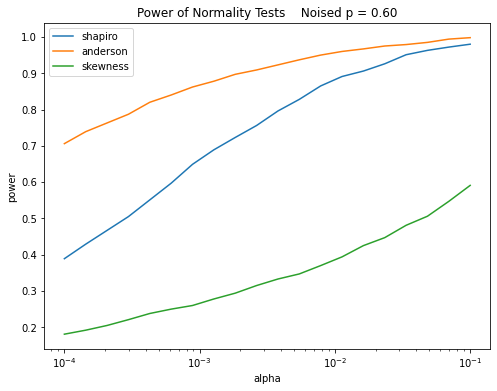

In [40]:
# Test normality of a sample
import numpy as np
from scipy.stats import norm, shapiro
from statsmodels.stats.diagnostic import normal_ad

def skewness_test(x):
    # return p-value
    n = x.size
    x = x - x.mean()
    s = (x**3).mean() / (x**2).mean() ** 1.5
    var = 6*(n-2) / (n+1) / (n+3)
    t = s / var ** .5
    return 2 * norm.cdf(-abs(t))

anderson_test = lambda x: normal_ad(x)[1]
shapiro_test = lambda x: shapiro(x).pvalue

def noised_gaussian(n, p = .9, var1 = 1, var2 = 100):
    # A mixed gaussian distribution that has probability p to be N(0, var1) and 1-p to be N(0, var2).
    ps = np.random.random(n) < p
    samples = np.random.randn(n)
    samples = np.where(ps, samples * np.sqrt(var1), samples * np.sqrt(var2))
    return samples

METHODS = {'shapiro': shapiro_test, 'anderson': anderson_test, 'skewness': skewness_test}
pvalues = {method: [] for method in METHODS}
n = 30
times = 1000
noised_p = 0.6

np.random.seed(0)
for time_ in range(times):
    x = noised_gaussian(n, p = noised_p)
    for method, func in METHODS.items():
        pvalues[method].append(func(x))
pvalues = {method: np.array(pvalues[method]) for method in METHODS}

alphas = 10**np.linspace(-4, -1, 20).reshape((-1, 1))
power = {method: (p < np.tile(alphas, (1, times))).mean(axis = 1) for method, p in pvalues.items()}

from matplotlib import pyplot as plt
plt.figure(figsize = (8, 6))
for method in METHODS:
    plt.plot(alphas.flatten(), power[method], label = method)
plt.title('Power of Normality Tests    Noised p = %.2f'%noised_p)
[plt.semilogx(), plt.legend(), plt.xlabel('alpha'), plt.ylabel('power')]
plt.show()

## References

[1] Reinaldo B. Arellano-Valle, Simone B. Harnik, and Marc G. Genton, [On the Asymptotic Joint Distribution of Multivariate Sample Moments](https://marcgenton.github.io/2021.AHG.bookchap.pdf), In: Ghosh, I., Balakrishnan, N., Ng, H.K.T. (eds) Advances in Statistics - Theory and Applications. Emerging Topics in Statistics and Biostatistics . Springer, Cham.

[2] [https://math.stackexchange.com/questions/92648/calculation-of-the-n-th-central-moment-of-the-normal-distribution-mathcaln](https://math.stackexchange.com/questions/92648/calculation-of-the-n-th-central-moment-of-the-normal-distribution-mathcaln)

[3] [https://handwiki.org/wiki/Shapiro%E2%80%93Wilk_test](https://handwiki.org/wiki/Shapiro%E2%80%93Wilk_test)

[4] [https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm)